# 0 Setup

In [3]:
#Contribute by Cheng-Wei Liao, Justin Borgmann

#install.packages(c("R.utils","ggplot2","tidyverse","MatrixEQTL"))
#install.packages("BiocManager")
#BiocManager::install("preprocessCore")

In [2]:
library(data.table)
library(R.utils)
library(ggplot2)
library(preprocessCore)
library(reshape2)
library(tidyverse)
library(MatrixEQTL)

Warning message:
"package 'R.utils' was built under R version 4.1.2"
Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.


Attaching package: 'R.oo'


The following object is masked from 'package:R.methodsS3':

    throw


The following objects are masked from 'package:methods':

    getClasses, getMethods


The following objects are masked from 'package:base':

    attach, detach, load, save


R.utils v2.11.0 (2021-09-26 08:30:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: 'R.utils'


The following object is masked from 'package:utils':

    timestamp


The following objects are masked from 'package:base':

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings


Warning message:
"package 'ggplot2' was built under R version 4.1.2"
Warning messa

# 1 Introduction example (5 points)

### Task: Load the data frame in eqtl_examples.RDS and calculate if gene1 and snp1 are associated with each other, using gender as a covariate

In [3]:
example <-readRDS("eqtl_examples.RDS")
summary(lm(gene1~snp1 +gender, data = example))


Call:
lm(formula = gene1 ~ snp1 + gender, data = example)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4985 -0.4084  0.0006  0.4066  2.1128 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.72917    0.05026  14.507   <2e-16 ***
snp1        -1.07259    0.04274 -25.093   <2e-16 ***
gender       0.09483    0.06069   1.562    0.119    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6367 on 442 degrees of freedom
Multiple R-squared:  0.5877,	Adjusted R-squared:  0.5858 
F-statistic:   315 on 2 and 442 DF,  p-value: < 2.2e-16


#### We can see the p-value for gender is not smaller than 0.05 and gene have p-value less then 0.05.  We can say gene1 are associated with snp1.

### Task: Visualize the relationship between gene1 and snp1 with a boxplot.

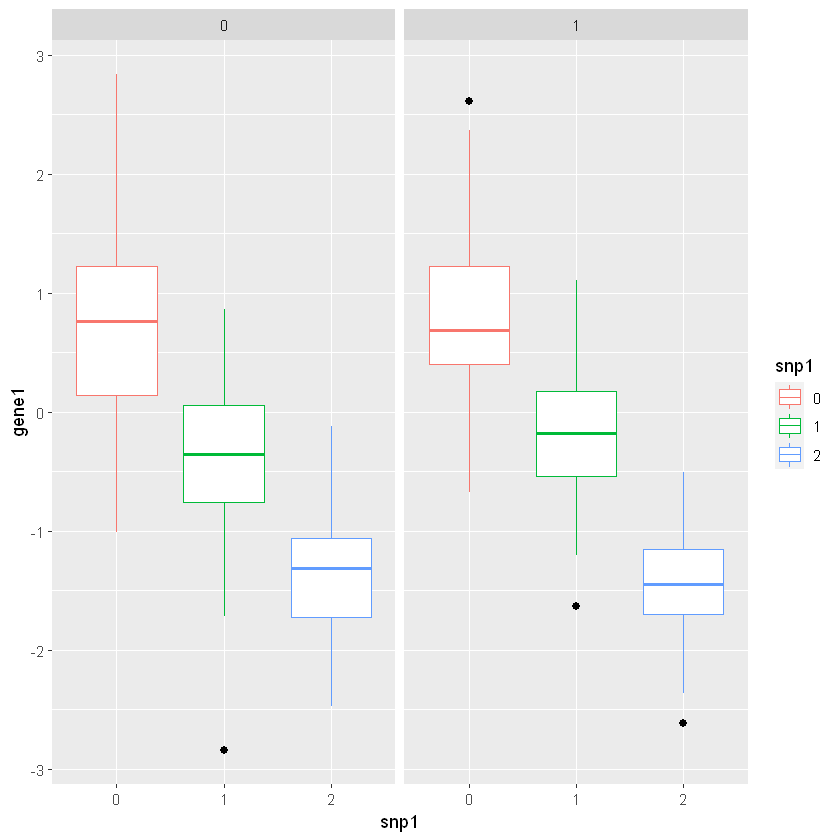

In [4]:
example$snp1 <- as.character(example$snp1)
ggplot(example, aes(snp1,gene1,color = snp1)) + geom_boxplot(outlier.colour="black", outlier.shape=16,
                                                outlier.size=2, notch=FALSE)+facet_wrap(~gender)

### Introduction about eQTLs:

#### What is an eQTL and what is the difference between cis and trans eQTLs?

### An eQTL is a locus that explains a fraction of the genetic variance of a gene expression phenotype.
### Cis-eQTLs are eQTLS located near the gene of origin, you could also say the local eQTLs. 
###    Trans-eQTLs are the ones located distant from the gene of origin, often even on different chromosomes.

#### What is the statistical approach to identify eQTLs? Write down the model.

### Complexity and noise in expression quantitative trait loci studies make it difficult to distinguish potential regulatory relationships among the many interactions, so we want to determine the significance of an association between an expression trait and a locus with respect to the set of all associations to the expression trait and for that we need the statistical approach.

#### How are eQTLs related to GWAS studies?

### eQTL studies try to identify genetic variants that affect the expression of one or more genes, wheres GWAS studies are used in genetics research to associate specific genetic variations with particular diseases. The method involves scanning the genomes from many different people and looking for genetic markers that can be used to predict the presence of a disease. So, what we want to do, is to perform eQTL analysis on these GWAS results to explain their meaning.

# 2 Data preprocessing (15 points)

## 2.1 Preprocessing of gene expression data

### Visualize the count distribution of the first 50 genes and the first 50 samples afterwards using boxplots
(The meaning of this sentence is a little bit ambiguous, for 1 histogram 1 boxplots or 2 histogram 2 boxplots)

In [5]:
gd660 <- fread("GD660.GeneQuantRPKM.txt.gz")

In [6]:
matrix1 <- gd660[,1:4]
matrix2 <- gd660[,-(1:4)]
matrix2 <- data.matrix(matrix2)
row.names(matrix2)<- matrix1$TargetID
convered_matrix2 <- matrix2[rowMeans(matrix2!=0) >0.5, ]
convered_matrix2[convered_matrix2 == 0] <- 1
convered_matrix2 <- log2(convered_matrix2)

In [7]:
#for gene plotting
cut_matrix2 <- convered_matrix2[1:50,]
cut_matrix2 <- data.frame(cut_matrix2)

unlist_matrix2 <- unlist(cut_matrix2)
unlist_matrix2 <- data.matrix(unlist_matrix2)
unlist_matrix2 <- data.frame(unlist_matrix2)

In [8]:
trans_unlist_matrix2 <- data.frame(t(cut_matrix2))
trans_unlist_matrix2 <- stack(trans_unlist_matrix2)

In [9]:
#for samples plotting
samples_matrix2 <- convered_matrix2[,1:50]
samples_matrix2 <- data.frame(samples_matrix2)
stack_matrix2 <- stack(samples_matrix2)

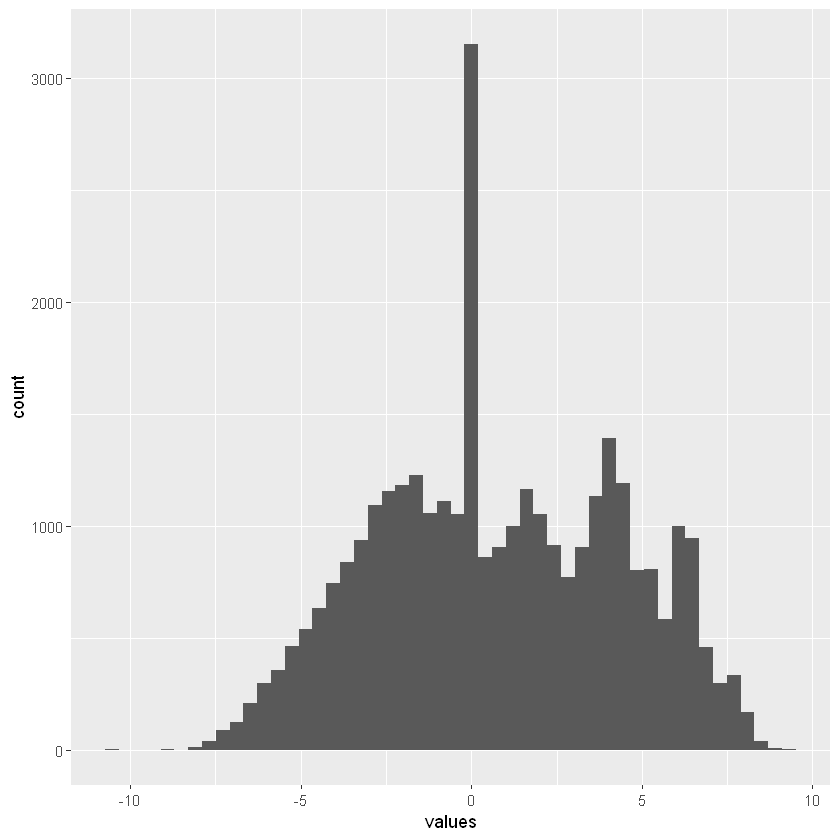

In [10]:
ggplot(unlist_matrix2,aes(x = unlist_matrix2))+
  geom_histogram(bins=50)+
  labs(x = "values")

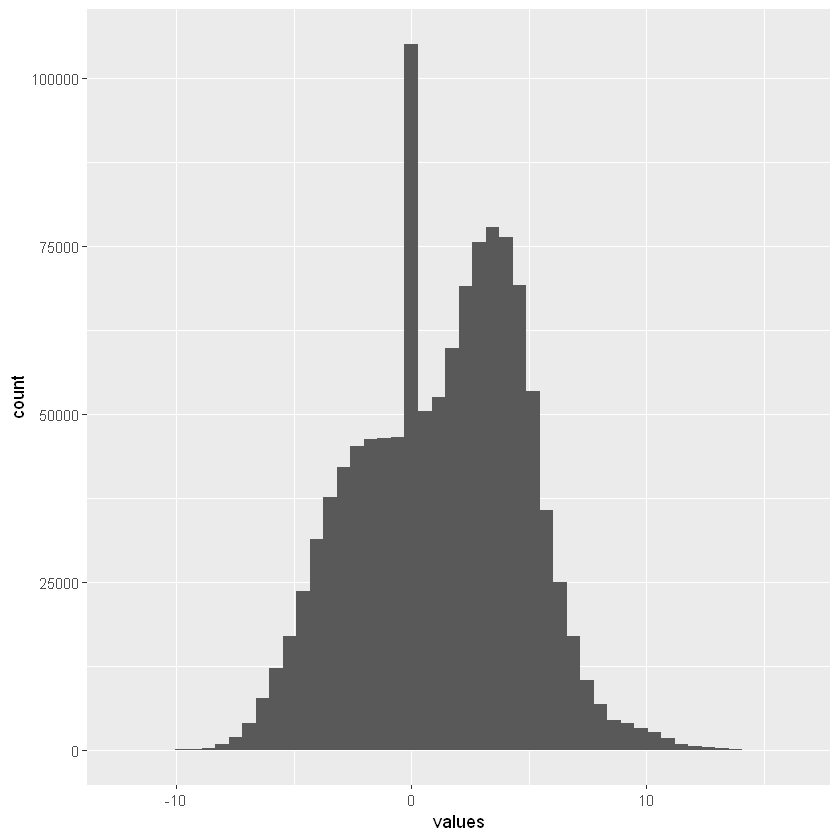

In [11]:
ggplot(stack_matrix2,aes(x = values))+
  geom_histogram(bins=50)+
  labs(x = "values")

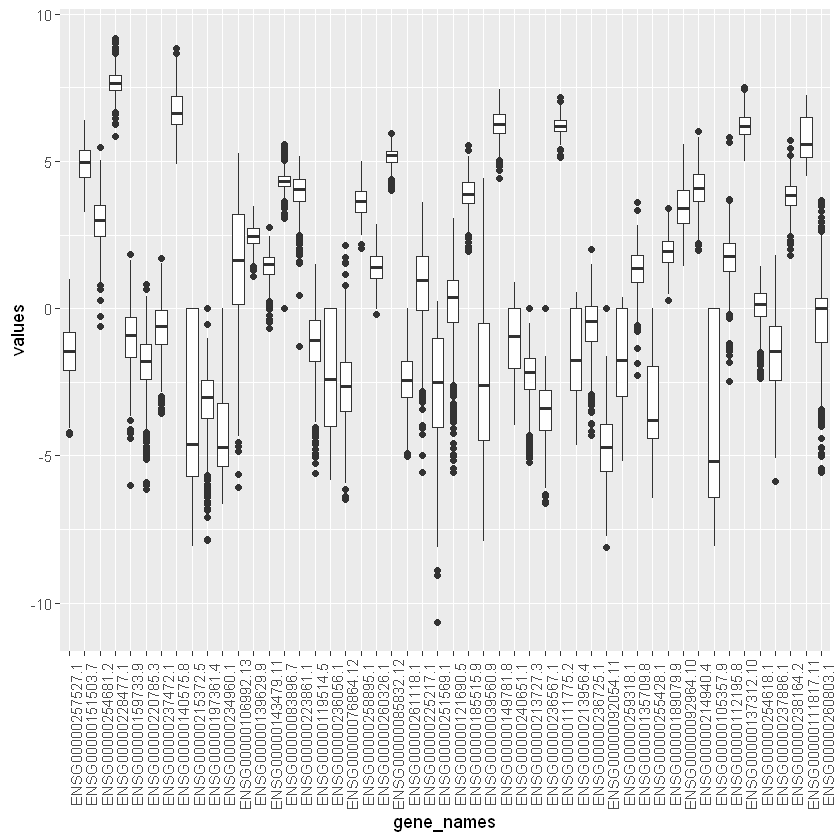

In [12]:
ggplot(trans_unlist_matrix2,aes(ind, values))+
  geom_boxplot()+
  labs(x = "gene_names", y = "values")+
theme(axis.text.x = element_text(angle = 90))

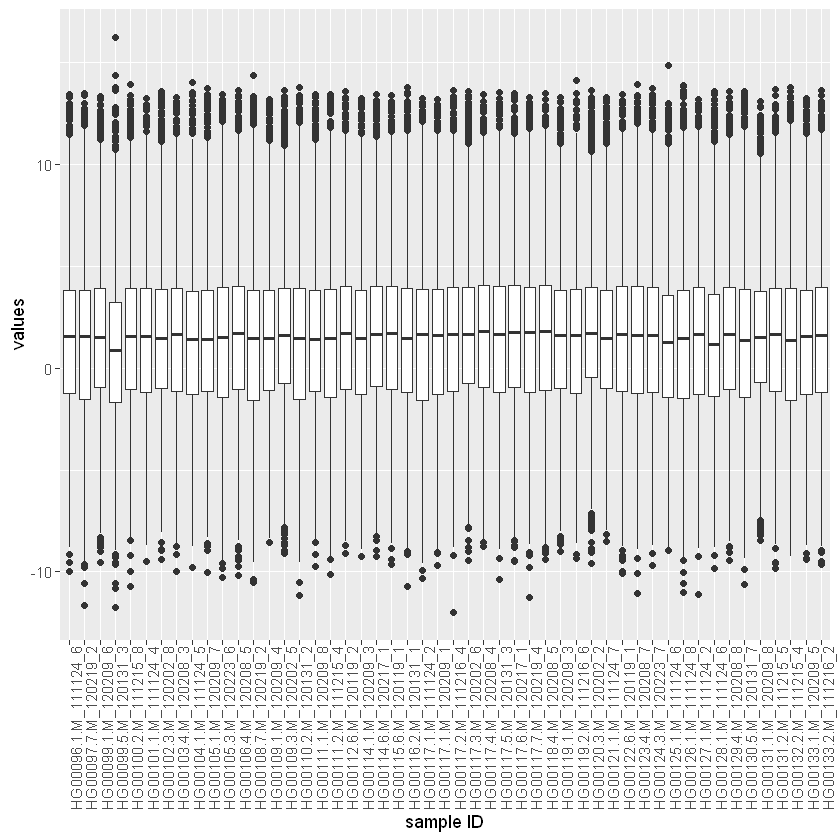

In [13]:
ggplot(stack_matrix2, aes(x = ind,y = values))+ 
geom_boxplot()+
labs(x = "sample ID")+
theme(axis.text.x = element_text(angle = 90))

### 2.1.1 Quantile normalization

### Repeat the boxplots from above after having applied quantile normalization

In [14]:
#quantail normarlization

quantile_normalisation <- function(df){
  df_rank <- apply(df,2,rank,ties.method="min")
  df_sorted <- data.frame(apply(df, 2, sort))
  df_mean <- apply(df_sorted, 1, mean)
  
  index_to_mean <- function(my_index, my_mean){
    return(my_mean[my_index])
  }
  
  df_final <- apply(df_rank, 2, index_to_mean, my_mean=df_mean)
  rownames(df_final) <- rownames(df)
  return(df_final)
}
nq_matrix2 <- quantile_normalisation(convered_matrix2)

In [15]:
trans_nq <- t(nq_matrix2[1:50,]) %>% data.frame() #first 50 genes
trans_nq <- stack(trans_nq)

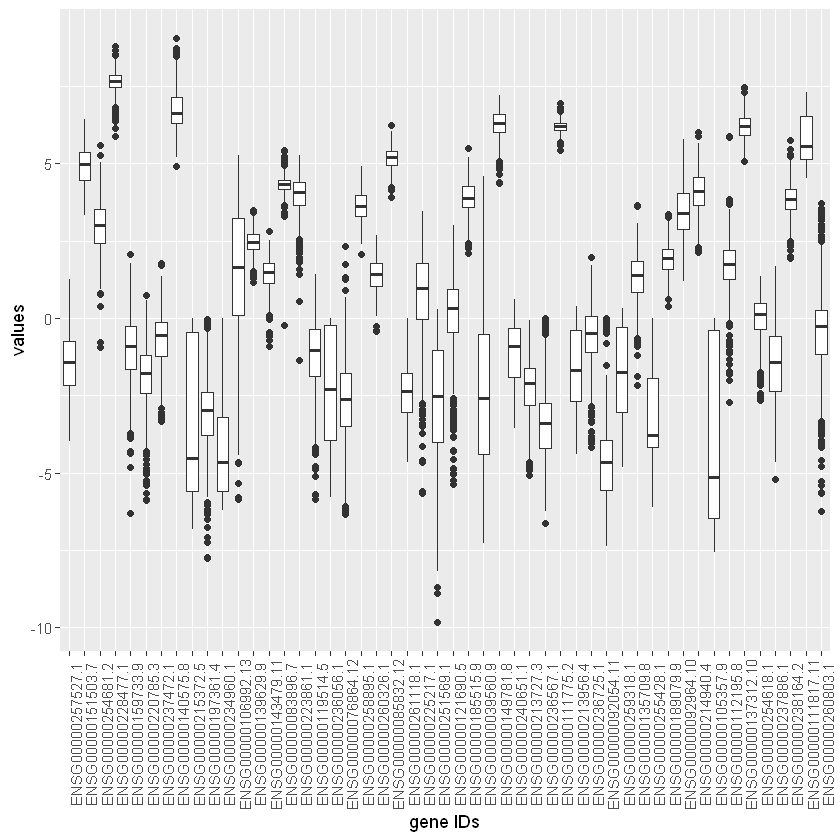

In [16]:
ggplot(trans_nq, aes(x = ind,y = values))+
geom_boxplot()+
theme(axis.text.x = element_text(angle = 90)) +
labs(x = "gene IDs")

In [17]:
nq <- nq_matrix2[,1:50] #first 50 samples
nq <- data.frame(nq)
nq <- stack(nq)

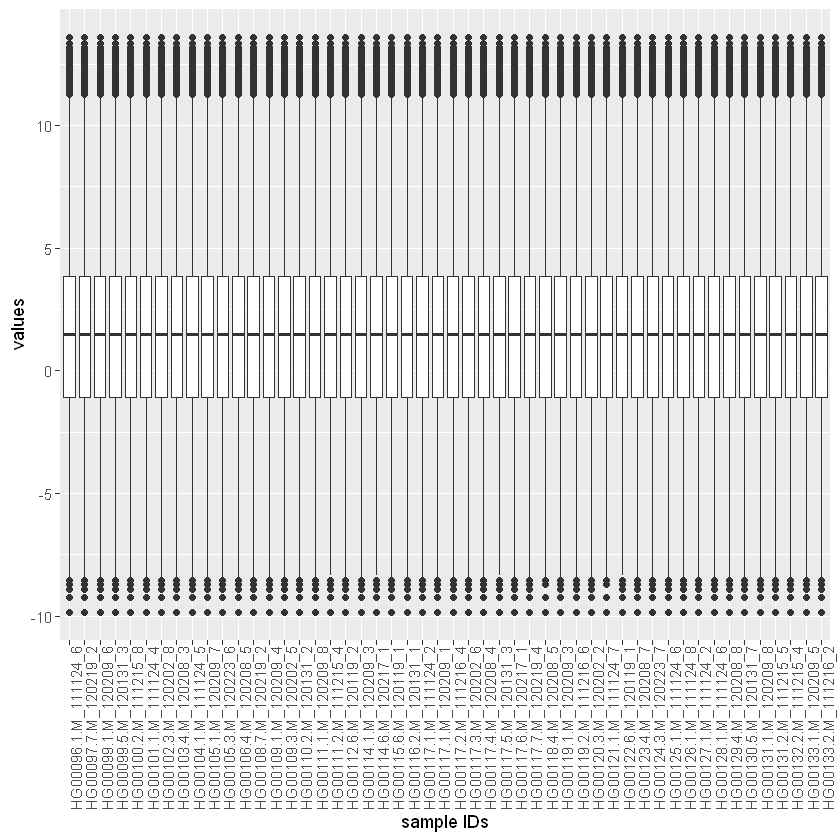

In [18]:
ggplot(nq, aes(x = ind,y = values))+
geom_boxplot()+
theme(axis.text.x = element_text(angle = 90)) +
labs(x = "sample IDs")

### Which changes can you observe? How is the quantile normalization calculated and what is the effect of it?

### The graphs are normalized and look identical, the quantile normalization is calculated by getting the rank of every gene of each sample, then sort the data in ascending order and get the average(mean) of the genes. Then get the average for genes occupying the same rank, and substitute the values of all genes occupying this certain rank with this average value. Last step is to reorder them in the original order. The effect of quantile normalization is you will receive distributions which are identical in statistical properties.

### Apply gene wise quantile normalization to transform the expression values to normal distribution and repeat the boxplot for the first 50 genes from above.

In [19]:
colnames(convered_matrix2) <- gsub("^([^.]+).*","\\1",colnames(convered_matrix2))
clean_name <- t(apply(convered_matrix2, 1, function(x) tapply(x, colnames(convered_matrix2), mean)))

In [20]:
#read table patients_edit.txt
patients <- read.table("patients_edit.txt",h=T)

In [21]:
#Remove all samples for which we have no sample annotation in the file patients_edit.txt
annotation_samples <- clean_name[, which(colnames(clean_name) %in% c(patients$sample))]

ranker <-  t(apply(-annotation_samples, 1, rank))
devided_ranker <- t(apply(ranker, 1, function(x) x/ncol(ranker)))
q_ranker <- qnorm(devided_ranker)

In [22]:
#Finally, apply gene wise quantile normalization to transform the expression values to normal distribution
gene_quantail_normal <- function(df){
  ranker <-  t(apply(-annotation_samples, 1, rank))
  devided_ranker <- t(apply(ranker, 1, function(x) x/ncol(df)))
  qnormal <- qnorm(devided_ranker)
  
  return(qnormal)
}
                            
qnormal_gene <- gene_quantail_normal(annotation_samples)

Warning message:
"Removed 50 rows containing non-finite values (stat_boxplot)."


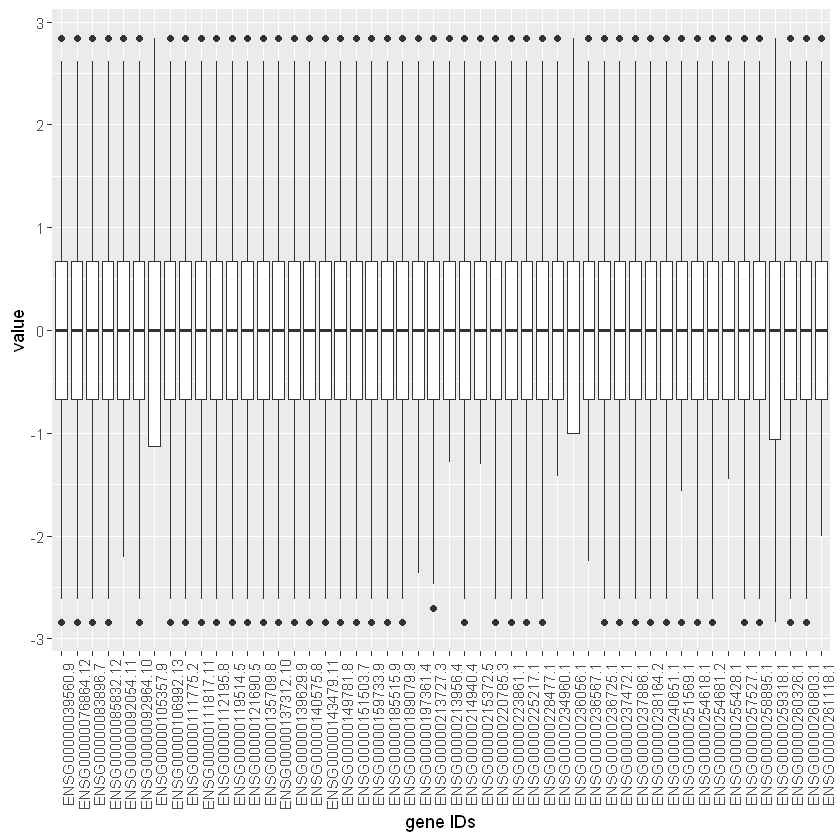

In [23]:
#plot genes
qnor_value <- qnormal_gene[1:50,]
qnor_value <- data.table(qnor_value, keep.rownames = T)
plotDat <- gather(qnor_value, key = "key", value = "value", -rn)
ggplot(plotDat, aes(rn, value)) +
  geom_boxplot()+
  theme(axis.text.x = element_text(angle = 90)) +
  labs(x = "gene IDs")

### Add to your report the five generated plots, explain what you see in them and why this is necessary for the eQTL analysis. 

### Some genes look different from others, and seem to have different statistical properties

### 2.1.2 Gene annotations

### How many samples and genes are left now in the end for the eQTL analysis?

In [24]:
gene_position <- fread("gene_position.tsv")

In [25]:
#remove gene at position X,Y, MT from file
gene_position <- gene_position[!which(gene_position$chromosome_name == "X" |gene_position$chromosome_name == "Y"| gene_position$chromosome_name == "MT"),]

In [26]:
#delete version number
rownames(qnormal_gene) <- gsub("^([^.]+).*","\\1",rownames(qnormal_gene))

In [27]:
#remove gene not in the file
cleaned_qnormal_gene <- qnormal_gene[which(rownames(qnormal_gene) %in% gene_position$ensembl_gene_id ),]

In [28]:
nrow(cleaned_qnormal_gene) #21877 gene rest
ncol(cleaned_qnormal_gene) #445 samples

[1] 21877

[1] 445

#### 21877 genes and 445 samples left 

## 2.2 Reformatting the SNP data

### Add to your report the plink command that you used to format the SNPs.

#### plink --vcf chr22.vcf --geno 0.9 --maf 0.05 --hwe 1e-3 --keep keep_SNPdata.tsv --snps-only --recode A-transpose --out SNP-file

### How many variants are left for the chromosome after filtering?

In [29]:
SNPdata <- read.table("SNP-file.traw", h=T)

In [30]:
nrow(SNPdata)

[1] 79341

#### 79341 variants

## 2.3 Covariates

### 2.3.1 Measured Covariates

### How many individual are male / female in the filtered data set?

In [31]:
samples <- colnames(cleaned_qnormal_gene) 
keep_names <- data.frame(samples,samples)

In [32]:
patients_V2 <- data.frame(patients)
patients_V2 <- patients_V2[which(patients_V2$sample %in% samples),]
patients_V2$gender <- ifelse(patients_V2$gender == "male","1","0")

In [33]:
sum(patients_V2$gender == "1") #male 209
sum(patients_V2$gender == "0") #female 236

[1] 209

[1] 236

#### Male 209, Female 236

### Why is it important to consider the gender for the eQTL analysis?

### Because sex differences also means genetic differences due to all the genetic variations and for each sex, you will receive different results and there are also gender specific diseases, i.e more/less likely to be received by one gender.

### 2.3.2 Hidden factors (PEER)

#### Did any of the factors capture patterns inherent in the known covariates? Choose a visualization for the relationship between the factor and the known covariate(s).

### Discussion about PEER factors

### Using PEER factors helps with the interpretability of the anaylsis due to the consideration of hidden determinants in the data and taking any known covariates into account. It also helps with using the learned factors in alternative genetic analysis. But it does NOT offer low-level data processing, like precprocessing has do be done prior and via other tools. It is also not made for the use with population structure information which is not encoded by covariates. Mixed modeling is also NOT supported.

In [34]:
peer_table <- read.csv("Estimated_Peer_Factors.csv")

In [35]:
relation_test <- merge(patients_V2, peer_table, by ="sample" )

In [36]:
long_relation_test <- melt(relation_test, id.vars = c("sample","pop","super_pop","gender"), variable.name = "peer")

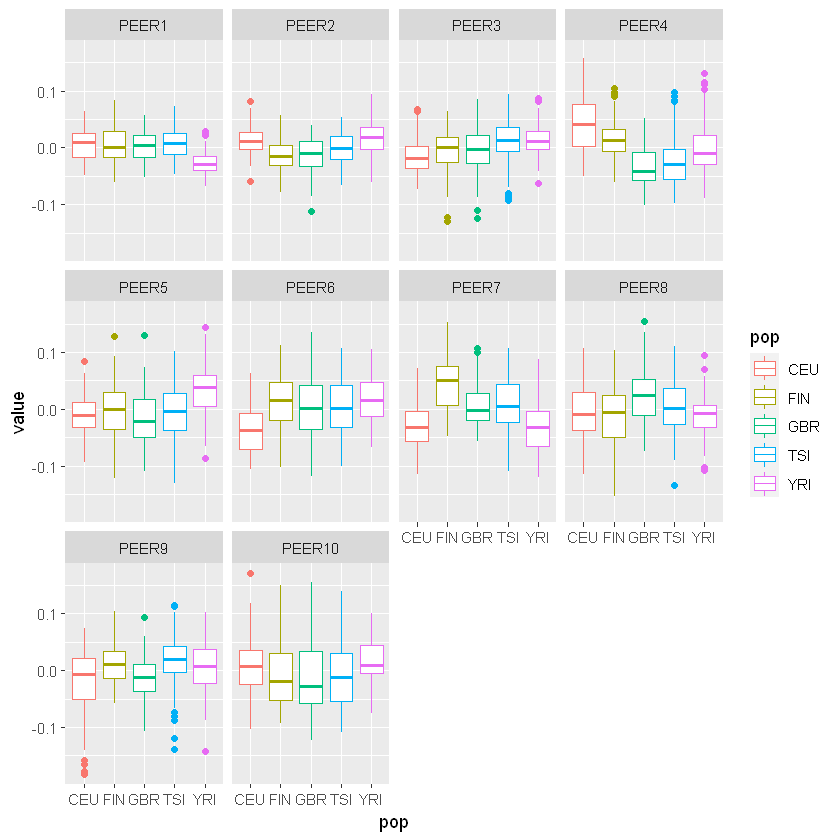

In [37]:
ggplot(long_relation_test, aes(pop,value, color = pop))+
  geom_boxplot()+
  facet_wrap(~peer)

#### Test if the second example pair gene2 and snp2 is an eQTL. 

In [38]:
summary(lm(gene2~snp2 +gender, data = example))


Call:
lm(formula = gene2 ~ snp2 + gender, data = example)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.02235 -0.63553  0.01643  0.63391  2.71924 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.10599    0.06508  -1.629    0.104    
snp2         0.65679    0.11621   5.652 2.85e-08 ***
gender       0.02769    0.09108   0.304    0.761    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9575 on 442 degrees of freedom
Multiple R-squared:  0.0674,	Adjusted R-squared:  0.06318 
F-statistic: 15.97 on 2 and 442 DF,  p-value: 2.01e-07


### Without Peers as covariates, gene2 p-value < 0,05. Yes

In [39]:
example$sample <- rownames(example)
merged_relation <- merge(example, relation_test, by = c("sample","gender"))

In [40]:
summary(lm(gene2 ~gender+snp2+PEER1+PEER2+PEER3+PEER4+PEER5+PEER6+PEER7+PEER8+PEER9+PEER10, data = merged_relation))


Call:
lm(formula = gene2 ~ gender + snp2 + PEER1 + PEER2 + PEER3 + 
    PEER4 + PEER5 + PEER6 + PEER7 + PEER8 + PEER9 + PEER10, data = merged_relation)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.60693 -0.47780  0.04893  0.50485  1.76975 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.067106   0.049321  -1.361 0.174346    
gender       0.107660   0.070195   1.534 0.125829    
snp2         0.116847   0.094595   1.235 0.217414    
PEER1       -7.525519   1.154752  -6.517 2.00e-10 ***
PEER2        3.542272   1.108915   3.194 0.001504 ** 
PEER3        3.291871   0.917756   3.587 0.000373 ***
PEER4       -6.364216   0.689290  -9.233  < 2e-16 ***
PEER5        5.386369   0.691395   7.791 5.01e-14 ***
PEER6        6.704689   0.673721   9.952  < 2e-16 ***
PEER7       -4.386766   0.690853  -6.350 5.47e-10 ***
PEER8       -4.609687   0.711202  -6.482 2.48e-10 ***
PEER9       -0.003191   0.722191  -0.004 0.996477    
PEER10      -2.212204   0.

### With peers as covariates, gene2 p-value < 0.05. No

### What is the effect size and significance of the SNP in both models?   

### Which of the covariates are significant?

#### With peers: gene2
#### Without peers: Peer1, Peer2, Peer3, Peer4, Peer5,  Peer6, Peer7,  Peer8, Peer9

### How can you explain this effect?

### Because PEER takes hidden factors into account which may lead to covariates seemingly be significant when not modeled with PEER, and therefore PEER shows way less significant covariates.

### Visualize the relationship between expression and genotype dependent on the PEER factors

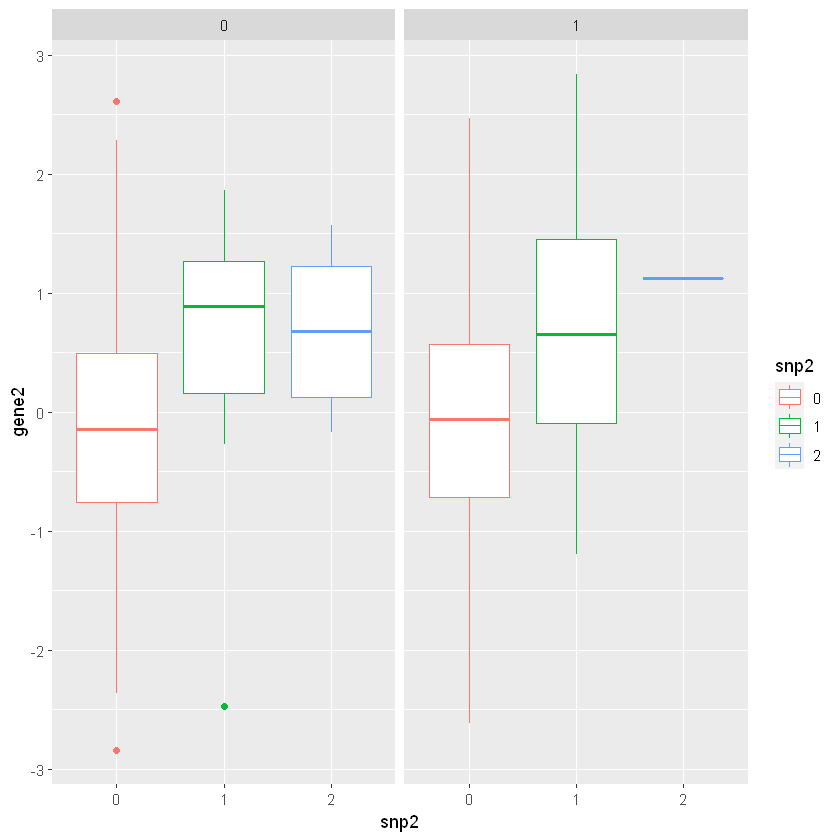

In [41]:
example$snp2 <- as.character(example$snp2)
ggplot(example,aes(snp2,gene2,color = snp2))+geom_boxplot()+facet_wrap(~gender)

### What do you observe? Explain the difference between the expression values and the expression residuals.

### In the residuals 1 less factor is being noticed

### 2.3.3 Reformat all covariates for matrix eQTL

In [42]:
matrix_eQTL_format <- t(relation_test)
colnames(matrix_eQTL_format) <- relation_test$sample
matrix_eQTL_format <- matrix_eQTL_format[4:nrow(matrix_eQTL_format),]

# 3 eQTL analysis (15 points)

In [43]:
genotype <- SNPdata[,c(2,7:ncol(SNPdata))]
genotype_name <- colnames(genotype) 
expression <- subset(cleaned_qnormal_gene, colnames(cleaned_qnormal_gene) %in% colnames(genotype))

## Explain in your report, why many studies restrict the analysis to cis eQTLs.

### cis-eqtl have more relevancy due to them being related to cisregulatory elements and therefore directly influencing gene expression -> they represent a polymorphism physically located near the gene itself.

In [44]:
#covariate
covariate <- matrix_eQTL_format

#gene location
genelocation <- gene_position[,c(1,2,3,4)]

#SNP location
snplocation <- SNPdata[c(2,1,4)]

#expression
express <- readRDS("expression.RDS")

In [45]:
# Only associations significant at this level will be saved
pvOutputThreshold_cis = 1e-6;
pvOutputThreshold_tra = 0;

# Error covariance matrix
# Set to numeric() for identity.
errorCovariance = numeric();

# Distance for local gene-SNP pairs
cisDist = 1e6;

useModel = modelLINEAR
snps = SlicedData$new();
snps$fileDelimiter = "\t";      # the space character
snps$fileOmitCharacters = "NA"; # denote missing values;
snps$fileSkipRows = 1;          # one row of column labels
snps$fileSkipColumns = 1;       # one column of row labels
snps$fileSliceSize = 2000;      # read file in pieces of 2,000 rows
snps$LoadFile("genotype.tsv");


gene = SlicedData$new();
gene$fileDelimiter = "\t";      # the space character
gene$fileOmitCharacters = "NA"; # denote missing values;
gene$fileSkipRows = 1;          # one row of column labels
gene$fileSkipColumns = 1;       # one column of row labels
gene$fileSliceSize = 2000;      # read file in pieces of 2,000 rows
gene$LoadFile("ms_expression.tsv");


snpspos = read.table("SNP_location.tsv", header = T, stringsAsFactors = FALSE);
genepos = read.table("genelocation.tsv", header = T, stringsAsFactors = FALSE);
output_file_name_cis ="output_cis.tsv";
output_file_name_tra = "output_trans.tsv";


cvrt= SlicedData$new();
cvrt$fileDelimiter = "\t";      # the space character
cvrt$fileOmitCharacters = "NA"; # denote missing values;
cvrt$fileSkipRows = 1;          # one row of column labels
cvrt$fileSkipColumns = 1;       # one column of row labels
cvrt$fileSliceSize = 2000;      # read file in pieces of 2,000 rows
cvrt$LoadFile("covariate.tsv");

me = Matrix_eQTL_main(
  snps = snps,
  gene = gene,
  cvrt = cvrt,
  useModel = useModel,
  output_file_name = output_file_name_tra,
  pvOutputThreshold = pvOutputThreshold_tra,
  errorCovariance = errorCovariance,
  verbose = TRUE,
  output_file_name.cis = output_file_name_cis,
  pvOutputThreshold.cis = pvOutputThreshold_cis,
  snpspos = snpspos,
  genepos = genepos,
  cisDist = cisDist,
  pvalue.hist = TRUE,
  min.pv.by.genesnp = FALSE,
  noFDRsaveMemory = TRUE);

qq_me = Matrix_eQTL_main(
  snps = snps,
  gene = gene,
  cvrt = cvrt,
  useModel = useModel,
  output_file_name = output_file_name_tra,
  pvOutputThreshold = pvOutputThreshold_tra,
  errorCovariance = errorCovariance,
  verbose = TRUE,
  output_file_name.cis = output_file_name_cis,
  pvOutputThreshold.cis = pvOutputThreshold_cis,
  snpspos = snpspos,
  genepos = genepos,
  cisDist = cisDist,
  pvalue.hist = "qqplot",
  min.pv.by.genesnp = FALSE,
  noFDRsaveMemory = TRUE);

Rows read: 2,000

Rows read: 4,000

Rows read: 6,000

Rows read: 8,000

Rows read: 10,000

Rows read: 12,000

Rows read: 14,000

Rows read: 16,000

Rows read: 18,000

Rows read: 20,000

Rows read: 22,000

Rows read: 24,000

Rows read: 26,000

Rows read: 28,000

Rows read: 30,000

Rows read: 32,000

Rows read: 34,000

Rows read: 36,000

Rows read: 38,000

Rows read: 40,000

Rows read: 42,000

Rows read: 44,000

Rows read: 46,000

Rows read: 48,000

Rows read: 50,000

Rows read: 52,000

Rows read: 54,000

Rows read: 56,000

Rows read: 58,000

Rows read: 60,000

Rows read: 62,000

Rows read: 64,000

Rows read: 66,000

Rows read: 68,000

Rows read: 70,000

Rows read: 72,000

Rows read: 74,000

Rows read: 76,000

Rows read: 78,000

Rows read: 79341 done.

Rows read: 2,000

Rows read: 4,000

Rows read: 6,000

Rows read: 8,000

Rows read: 10,000

Rows read: 12,000

Rows read: 14,000

Rows read: 16,000

Rows read: 18,000

Rows read: 20,000

Rows read: 21893 done.

Rows read: 11 done.

Matching

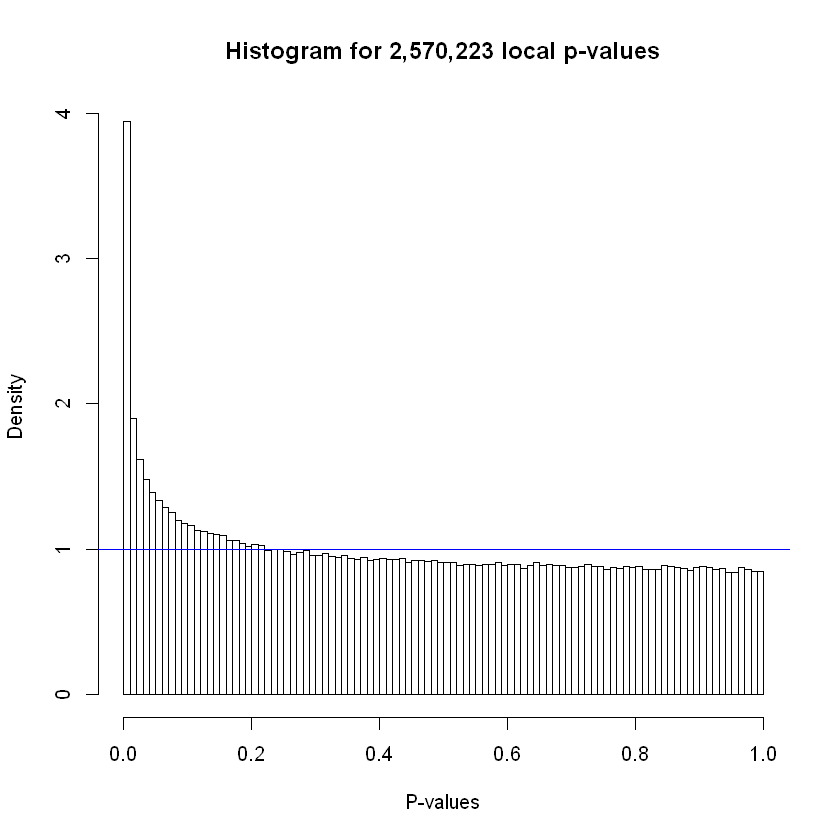

In [46]:
plot(me)

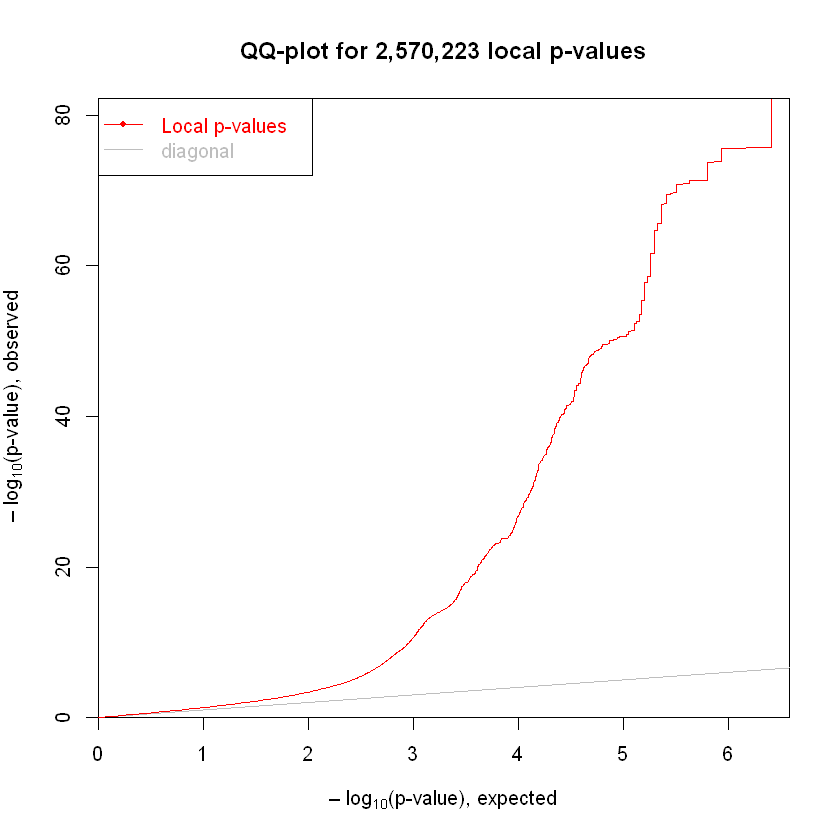

In [47]:
plot(qq_me)

## Does the distribution look like expected?

#### It looks somehow as expected, the flat distribution along the bottom does make sense considering all 0 p-values, and between 0 and 1 they are uniformly distributed. And the peak close to 0 also makes sense, since this is where the alternative hypotheses lies along with some potential false positives.

### How many tests were done and what the Bonferroni corrected significance threshold corresponding to a Family-wise error rate (FWER) < 0.05.

In [48]:
me$cis$ntests
#2570223 tests

#bonferroni corrected a = 0.05/2570223 = 0.00000002
bonferroni_threshold = 0.05/2570223

[1] 2570223

### How many cis eQTLs you find with the primary threshold (p-value < 1e-6) and how many remain after filtering for FWER < 0.05. Why is multiple testing correction important?

In [49]:
output_cis <- read.table("output_cis.tsv",h = T)
sum(output_cis$p.value < bonferroni_threshold )
# 4444 after FWER<0.05

[1] 4444

####  With the primary threshold : 6871
#### Remain after filtering for FWER < 0.05 : 4444

#### FWER is calculated as 1-(1- a)^number_of_tests
#### If the threshold is not corrected = 0.05, with 6 tests, there is a 26.5% chance of 
#### discovering one or more false-positive results.
#### With Bonferroni corrected threshold (a/number_of_tests) 
#### 1-(1-0.008)^6 = 4.7%
#### For bonferroni correction keeps FWER at 5% 
#### Bonferroni correction adjust the probability value to avoid increased risk
#### of Type I error when making multiple statistical tests.

## 3.1 Rerun the analysis for more chromosomes

### Create a table in your report with chromosome, number of cis eQTls with uncorrected p-value < 1e-6 and number of cis eQTLs with FWER < 0.05.

| Chrmosome | p-value < 1e-6 | FWER < 0.05 | total tests| Bonferroni threshold |
| --- | --- | --- | --- | --- |
| Ch22 | 6871 | 4444 | 2570223 |1.94535649e-8|
| Ch1 | 2079 | 1269 |2570223 |1.94535649e-8|
| Ch6 | 53267 | 34246 |7128130| 7.01446242e-9|
| Ch11 | 11962 | 6483 |4880409| 1.0245043e-8|

| Total number of tests | Bonferroni threshold |
| --- | ---|
|17148985 |2.91562445e-9|

# 4 Annotating eQTLs (15 points)

## 4.1 Genomic distance of cis eQTLs

### Plot a histogram of the distance between TSS and SNP, what do you observe?

Warning message in ch22_tss_loc_sort - ch22_snp_loc_sort:
"longer object length is not a multiple of shorter object length"


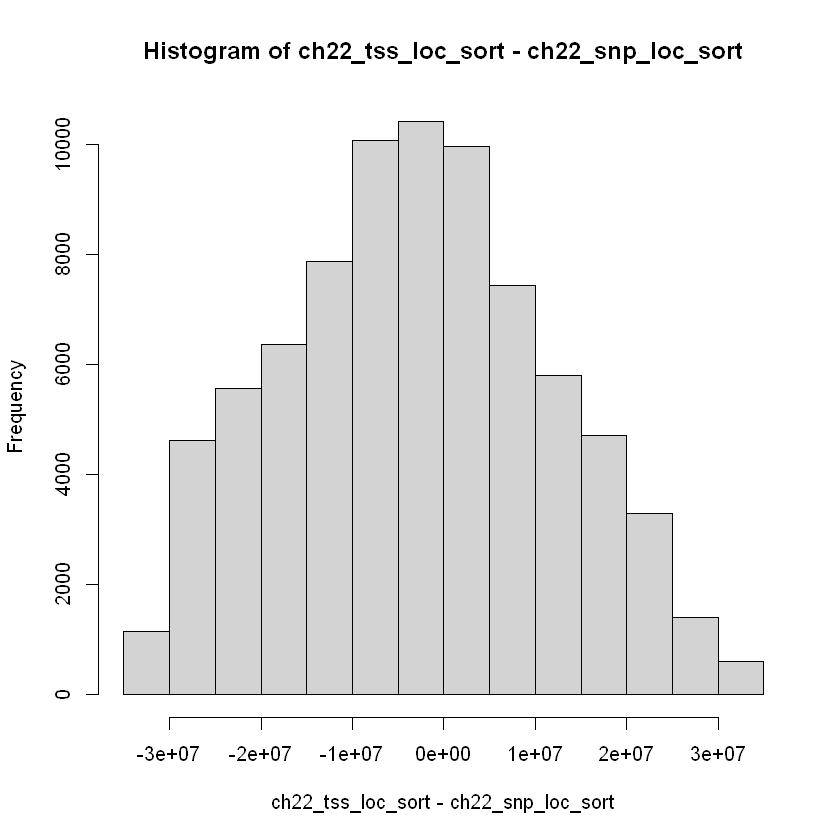

In [2]:
#4.1 Genomic distance of cis eQTLs
snpspos = read.table("SNP_location.tsv", header = T, stringsAsFactors = FALSE)
genepos = read.table("genelocation.tsv", header = T, stringsAsFactors = FALSE)


gene_loc_22 <- subset(genepos, chromosome_name == 22)
ch22_tss_loc <- as.numeric(unlist(gene_loc_22[3]))

ch22_tss_loc_sort <- ch22_tss_loc[order(ch22_tss_loc)]
ch22_snp_loc <- as.numeric(snpspos$POS)

ch22_snp_loc_sort <- ch22_snp_loc[order(ch22_snp_loc)]

hist(ch22_tss_loc_sort- ch22_snp_loc_sort)

#### Data shows a normal distribution, that means most of the distance between TSS and SNP are close to each other.

In [53]:
#build data frams
ch22_cis_eqtl <- read.table("output_cis.tsv",h=T)
ch22_max_beta <- ch22_cis_eqtl %>% group_by(SNP) %>% top_n(1,abs(beta))

ch22_ceqtl_dis <- data.frame(ch22_cis_eqtl)


ch22_snp_loc <-as.numeric(gsub("^[^-]*_([^_]+).*", "\\1", ch22_ceqtl_dis$SNP))
ch22_ceqtl_dis$snp_loc <- ch22_snp_loc

ch22_result <- cbind(ch22_ceqtl_dis, genepos[match(ch22_ceqtl_dis$gene,genepos$ensembl_gene_id),3])
ch22_result$distance <-as.numeric(abs(ch22_result$`genepos[match(ch22_ceqtl_dis$gene, genepos$ensembl_gene_id), `- ch22_result$snp_loc ))


split(ch22_cis_eqtl, ch22_cis_eqtl$gene)

ch22_nearest <- ch22_result %>% group_by(SNP) %>%top_n(-1,distance)

ch22_nearest <- as.data.frame.table(ch22_nearest)
#match nearest and most accosiated together


ch22_nearest$snp_gene <- paste(ch22_nearest$Freq.SNP,ch22_nearest$Freq.gene,sep = "-")
ch22_max_beta$snp_gene <- paste(ch22_max_beta$SNP, ch22_max_beta$gene, sep = "-")


,SNP,gene,beta,t.stat,p.value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
10,snp_22_17627274,ENSG00000069998,-0.6455272,-6.158217,1.684089e-09
11,snp_22_17628231,ENSG00000069998,-0.7498291,-5.248780,2.405723e-07
12,snp_22_17631893,ENSG00000069998,-0.6223379,-5.740346,1.781886e-08
13,snp_22_17634050,ENSG00000069998,-0.6223379,-5.740346,1.781886e-08
14,snp_22_17637210,ENSG00000069998,-0.7333891,-5.984090,4.573625e-09
15,snp_22_17639152,ENSG00000069998,-0.9447205,-6.653714,8.676708e-11
16,snp_22_17639299,ENSG00000069998,-0.9447205,-6.653714,8.676708e-11
17,snp_22_17639837,ENSG00000069998,-0.9447205,-6.653714,8.676708e-11
18,snp_22_17639918,ENSG00000069998,-0.8696123,-6.260549,9.263533e-10


In [61]:
nrow(ch22_max_beta)
nrow(ch22_nearest)

[1] 5286

[1] 42288

In [59]:
sum(ch22_max_beta$snp_gene %in% ch22_nearest$snp_gene) #4629/5286 = 0.88 
sum(ch22_nearest$snp_gene %in% ch22_max_beta$snp_gene) #37032/42288 = 0.88

[1] 4629

[1] 37032

### How, often is the nearest gene the gene with the strongest association?

#### About  88% of the nearest gene are with the strongest association

## 4.2 Annotate GWAS loci with eQTLs

### 4.2.1 Quantify overlap

### Write down in your report the absolute number and percentage of GWAS SNPs associated with at least one eQTL.

In [62]:
gwas_catalog <- read.table("gwas_catalog_v1_0_filtered.tsv", sep = "\t", h = T) 

catalog_duplicate <- gwas_catalog[!duplicated(gwas_catalog$SNPS),]


w = 0
for(x in catalog_duplicate$SNP_GENE_IDS){
  if(nchar(x) > 15){
    w = w+1
  }
}
w # 14 SNPs associated with at least one eQTL.

[1] 14

#### Absolute number: 14
#### Percentage: 14/112 = 12.5%

### Add also the motivation for this analysis, how can eQTLs help us to understand GWAS?

#### GWAS ignores the interaction of multiple genes and thereforce can not fully reveal the genetic susceptibility factors for diseases. You want to use the results of the GWAS, and then perform eQTL analysis on them to explain the GWAS results. You can say that GWAS gives us relevant regions with seemingly relevant SNPs, and eQTL check if those are really relevant by performing statistical anaylsis. 

### Explain in your report, why the LD is important when comparing GWAS and eQTLs. What other factors can you think of that affect our ability to detect eQTLs connected with GWAS hits?

#### Because LD  allows us to identifying genetic markers that tag the actual causal variants.
#### And in eQTL studies, there is an additional source of information that can be used to improve fine-mapping called allelic imbalance (AIM) that measures imbalance in gene expression on two chromosomes of a diploid organism. 

### How often at least one of the eQTL genes overlaps at least one of the annotations and in contrast how often the eQTL gene is not the nearest gene (so provides additional information about the locus)? Add both numbers to the report.

In [63]:
nrow(catalog_duplicate) #112
nrow(gwas_catalog) #154
#154-112 = 42  

catalog_duplicate <- gwas_catalog[!duplicated(gwas_catalog$UPSTREAM_GENE_ID),]
catalog_duplicate <- gwas_catalog[!duplicated(gwas_catalog$DOWNSTREAM_GENE_ID),]
catalog_duplicate <- gwas_catalog[!duplicated(gwas_catalog$SNP_GENE_IDS),]
nrow(catalog_duplicate) #38 left

[1] 112

[1] 154

[1] 38

#### About 42/154 = 27% of eQTL genes overlapes at least one of the annotations

### 4.2.2 Explore one GWAS example locus

### Which of the two genes can we prioritize for this GWAS loci after our eQTL analysis?

#### ENSG00000177951, ENSG00000177947

### Include in your explanation a plot with the genomic context of the SNP: plot the position of both genes, the position of the SNP and add the eQTL signal in this region.

In [66]:
x <- catalog_duplicate[grep("snp_11_838722",catalog_duplicate$DISEASE.TRAIT),]


# two genes ENSG00000177951, ENSG00000177947
gene_position <- fread("gene_position.tsv")
subset(gene_position, ensembl_gene_id == c("ENSG00000177951", "ENSG00000177947"))
# only ENSG00000177951 in the dataset with start position 167784

gwas_catalog$CHR_POS>162784 & gwas_catalog$CHR_POS<162784
subset(gwas_catalog, CHR_POS>162784&CHR_POS<172784, select = CHR_POS)

Warning message in ensembl_gene_id == c("ENSG00000280759", "ENSG00000183020", "ENSG00000281385"):
"longer object length is not a multiple of shorter object length"


ensembl_gene_id,chromosome_name,start_position,end_position,strand
<chr>,<chr>,<int>,<int>,<int>


ERROR: Error: operations are possible only for numeric, logical or complex types
